In [1]:
# импорт нужных библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
from statsmodels.stats.proportion import proportion_confint

In [24]:
#загрузка данных из файла
data = pd.read_csv("credit_card_default_analysis.csv")
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Задание 1. Размер кредитного лимита 

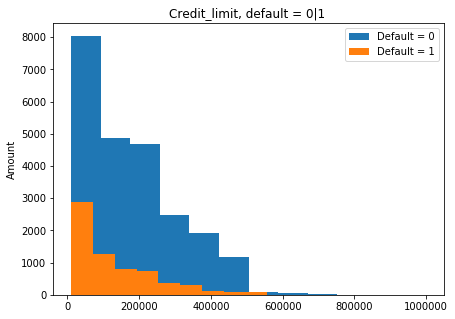

In [3]:
plt.figure(1, figsize=(7,5))

plt.title("Credit_limit, default = 0|1 ")
plt.hist(data.LIMIT_BAL[data.default == 0], label = "Default = 0", bins = 12)
plt.hist(data.LIMIT_BAL[data.default == 1], label = "Default = 1", bins = 12)
plt.ylabel('Amount');
plt.legend()

На графике видно, что распределение сумм невозврата кредита скошено влево. То есть, большинство невозвращенных кредитов - на маленькую сумму. Возможно, это связано с тем, что большинство кредитов, выданных банком - на маленькие суммы.

In [4]:
# создаем две переменные
limit_bal_0 = data.LIMIT_BAL[data.default == 0]
limit_bal_1 = data.LIMIT_BAL[data.default == 1]
print len(limit_bal_0), len(limit_bal_1)

23364 6636


In [5]:
# считаем медианы
median_0 = limit_bal_0.median()
median_1 = limit_bal_1.median()
print median_0, median_1

150000.0 90000.0


## Проверка гипотезы о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки:

Н0 - медианы равны; 

Н1 - медианы не равны

In [6]:
def zconfint_binom(n, p, alpha = 0.05):
    q = 1 - p
    m = n * p
    var = n * p * q
    z_stat = stats.norm.ppf(1 - alpha / 2)
    l_bound = int(round(m - z_stat * np.sqrt (var)))
    u_bound = int(round(m + z_stat * np.sqrt(var)))
    return (l_bound, u_bound)


In [7]:
lim_bal_0_s = np.sort(limit_bal_0.values)
lim_bal_1_s = np.sort(limit_bal_1.values)

l_ind_0, u_ind_0 = zconfint_binom(len(lim_bal_0_s), 0.5)
l_ind_1, u_ind_1 = zconfint_binom(len(lim_bal_1_s), 0.5)

print ("Interval median LIMIT_BAL, where default = 0: [%d, %d]" % (lim_bal_0_s[l_ind_0], lim_bal_0_s[u_ind_0]))
print ("Interval median LIMIT_BAL, where default = 1: [%d, %d]" % (lim_bal_1_s[l_ind_1], lim_bal_1_s[u_ind_1]))

Interval median LIMIT_BAL, where default = 0: [150000, 150000]
Interval median LIMIT_BAL, where default = 1: [80000, 90000]


In [8]:
def get_bootstrap(data, n_samples):
    incides = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[incides]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1-alpha/2.)])
    return boundaries

In [9]:
np.random.seed(0)

lim_bal_0_strap_med = map(np.median, get_bootstrap(limit_bal_0.values, 100))
lim_bal_1_strap_med = map(np.median, get_bootstrap(limit_bal_1.values, 100))

bound_0 = stat_intervals(lim_bal_0_strap_med, 0.05)
bound_1 = stat_intervals(lim_bal_1_strap_med, 0.05)

print("Interval median LIMIT_BAL, where default = 0: [%d, %d]" % (bound_0[0], bound_0[1]))
print("Interval median LIMIT_BAL, where default = 1: [%d, %d]" % (bound_1[0], bound_1[1]))

Interval median LIMIT_BAL, where default = 0: [150000, 150000]
Interval median LIMIT_BAL, where default = 1: [80000, 90000]


Как видим, интервалы разные и не пересекаются. Соответственно, медианы не совпадают

## Проверьте гипотезу о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.

### Сформулирую гипотезы для перестановочного критерия:

H0: распределения выборок равны

H1: распределения выборок значимо отличаются

In [10]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [11]:
print ("p-value: %f"% permutation_test(limit_bal_0, limit_bal_1, max_permutations = 1000))

p-value: 0.001000


Нулевая гипотеза отклоняется на уровне значимости 0.05 (с вероятностью 95% процентов), поскольку p-value: 0.001. Значимы ли результаты с практической точки зрения? Однозначно, потому что и среднее медиан так же значимо отличается. 

# Задание 2. Пол (SEX): 

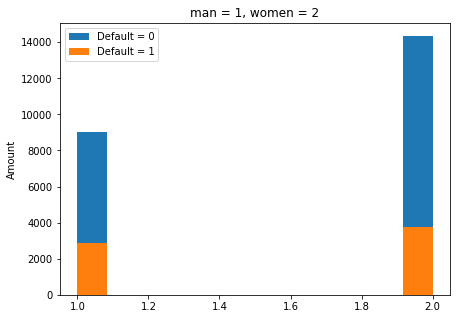

In [12]:
plt.figure(1, figsize=(7,5))

plt.title("Sex, default = 0|1 ")
plt.title("man = 1, women = 2")
plt.hist(data.SEX[data.default == 0], label = "Default = 0", bins = 12)
plt.hist(data.SEX[data.default == 1], label = "Default = 1", bins = 12)
plt.ylabel('Amount');
plt.legend()

Как видно по графику, женщины в сумме берут больше кредитов и их большее количество не возвращает. Но в процентном соотношении не так все очевидно, необходимо проводить дальнейший анализ.

In [13]:
# построение доверительных интервалов.
# разбиваем выборку на две части. Кто отдал кредит и кто не отдал.
sex_0 = data.SEX.loc[data.default == 0].values
sex_1 = data.SEX.loc[data.default == 1].values

# строим доверительные интервалы для доли мужчин в этих двух выборках:

conf_int_0 = proportion_confint(np.where(sex_0 == 1)[0].shape[0], sex_0.shape[0])
conf_int_1 = proportion_confint(np.where(sex_1 == 1)[0].shape[0], sex_1.shape[0])

print("MEN conf. inf. for default = 0 : [%.4f, %.4f]" % conf_int_0)
print("MEN conf. inf. for default = 1 : [%.4f, %.4f]" % conf_int_1)

MEN conf. inf. for default = 0 : [0.3796, 0.3921]
MEN conf. inf. for default = 1 : [0.4210, 0.4449]


Как видно с границ доверительных интервалов, они не пересекаються. Соответственно, и гендерная пропорция в выборках разная.

In [14]:
#  Z-критерий для разности долей (независимые выборки)
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

print ("Conf. int. of difference: [%f, %f]" % proportions_diff_confint_ind(np.abs(sex_0-2), np.abs(sex_1-2)))

Conf. int. of difference: [-0.060548, -0.033635]


Как видим, доверительный интервал для разности не включает в себя ноль. То есть, они статистически отличаются

## Z-критерий для разности долей (независимые выборки)

Н0: гендерный состав выборок не отличается

Н1: гендерный состав выборок отличается

In [15]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

print("p-value: %.15f" % proportions_diff_z_test(proportions_diff_z_stat_ind(np.abs(sex_0-2), np.abs(sex_1 - 2))) )

p-value: 0.000000000004473


p-value: 0.000000000004473, соответственно и нулевая гипотеза о равности долей мужского и женского пола в двух выборках отклоняется с уровнем значимости 0.05

## 3. Образование (EDUCATION): 

образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных

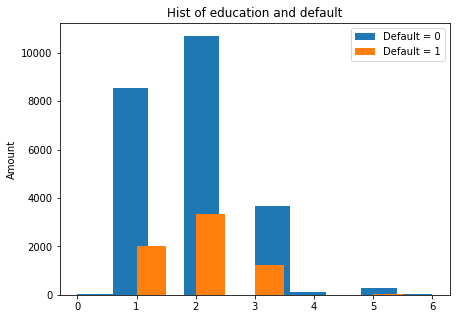

In [16]:
plt.figure(1, figsize=(7,5))

plt.title("Hist of education and default")
plt.hist(data.EDUCATION[data.default == 0], label = "Default = 0")
plt.hist(data.EDUCATION[data.default == 1], label = "Default = 1")
plt.ylabel('Amount');
plt.legend()

Как видно с гистограммы, большую часть кредитов берут люди с образованием уровня: бакалавр, магистр и выпускник школы. Остальные имеют очень низкую долю.

Сравним это распределение с равномерным, сделаем таблицу сопряженности для реальных и ожидаемых показателей.

### Проверим гипотезу о том, является ли распределение EDUCATION равномерным. Воспользуемся тестом ХИ-квадрат.

H0: у выборки равномерное распределение

Н1: у выборки не равномерное распределение

In [30]:
edu_num_0 = np.array([edu_0[edu_0 == ed_val].shape[0] for ed_val in range(7)] )
edu_num_1 = np.array([edu_1[edu_1 == ed_val].shape[0] for ed_val in range(7)] )
edu_num = edu_num_0 + edu_num_1

for i in range(7):
    print("Education level %d: %d / %d | %d" % (i, edu_num_0[i], edu_num_1[i], edu_num[i]))


Education level 0: 14 / 0 | 14
Education level 1: 8549 / 2036 | 10585
Education level 2: 10700 / 3330 | 14030
Education level 3: 3680 / 1237 | 4917
Education level 4: 116 / 7 | 123
Education level 5: 262 / 18 | 280
Education level 6: 43 / 8 | 51


In [43]:
exp_freq = np.array([0.86 * edu_num[i] for i in range(7)])

for i in range(7):
    print ("Education level %d: %d / %d | %d " % (i, exp_freq[i], edu_num_0[i], edu_num_0[i] - exp_freq[i]))

Education level 0: 12 / 14 | 1 
Education level 1: 9103 / 8549 | -554 
Education level 2: 12065 / 10700 | -1365 
Education level 3: 4228 / 3680 | -548 
Education level 4: 105 / 116 | 10 
Education level 5: 240 / 262 | 21 
Education level 6: 43 / 43 | 0 


Воспользуемся тестом Хи-квадрат, для принятия или отвержения нулевой гипотезы

In [44]:
stats.chisquare(edu_num_0, exp_freq, ddof = 1)

Power_divergenceResult(statistic=262.69838119247925, pvalue=1.0344900806883359e-54)

pvalue=1.0344900806883359e-54, соответственно отвергается нулевая гипотеза о том, что величина имеет равномерное распределение с уровнем значимости p = 0.05. Можно сделать вывод, что уровень образования влияет на то, будет возвращен кредит или не будет.

### Если клиент выпускник школы или бакалавр, то кредит с большей вероятностью не будет возвращен.

### Лучшие шансы возврата у людей: доктор, начальное образование или "прочее".

## 4. Семейное положение (MARRIAGE):

MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).

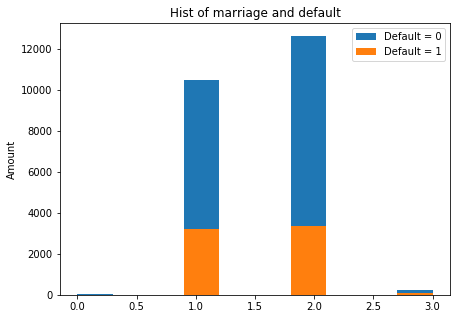

In [46]:
plt.figure(1, figsize=(7,5))

plt.title("Hist of marriage and default")
plt.hist(data.MARRIAGE[data.default == 0], label = "Default = 0")
plt.hist(data.MARRIAGE[data.default == 1], label = "Default = 1")
plt.ylabel('Amount');
plt.legend()

 Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.
 
 Как видим по графику, доли холостых и замужних людей примерно на одном и том же уровне, хотя холостых немного больше. 
 

In [50]:
# разделим выборку на две. Те, кто отдаст кредит и те, кто не отдаст

married = data.MARRIAGE
married_0 = data.MARRIAGE[data.default == 0]
married_1 = data.MARRIAGE[data.default == 1]

In [51]:
# посчитаем количество елементов каждого класса
married.value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [60]:
# Теперь сделаем таблицу сопряженности, что бы сравнить выборки с default = 0 и default = 1

tabl = np.empty((len(married.value_counts()), 2))
for i in range(len(married.value_counts())):
    tabl[i, 0] = len(married_0[married_0 == i ])
    tabl[i, 1] = len(married_1[married_1 == i])
tabl

array([[4.9000e+01, 5.0000e+00],
       [1.0453e+04, 3.2060e+03],
       [1.2623e+04, 3.3410e+03],
       [2.3900e+02, 8.4000e+01]])

Воспользуемся примером из лекции, а именно - коэффициент V Крамера. С его помощью сможем оценить, связаны ли эти выборки между собой.

In [63]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n * min(confusion_matrix.shape) - 1))

In [64]:
cramers_stat(tabl)

0.024379974780376065

Как видим, значение коэффициента составляет 0.024379974780376065. Это меньше уровня значимости 0.05 , соответственно можно утверждать, что взаимосвязь между выборками отсутствует. То есть, нет разницы, выдавать кредит замужнему или холостому человеку. 

## 5. Возраст (AGE):

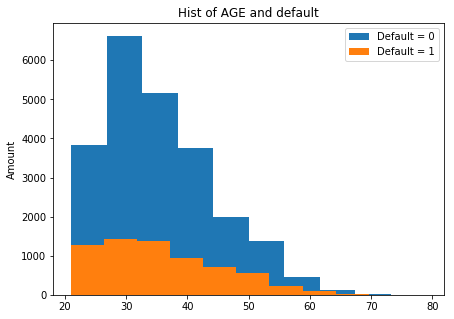

In [65]:
plt.figure(1, figsize=(7,5))

plt.title("Hist of AGE and default")
plt.hist(data.AGE[data.default == 0], label = "Default = 0")
plt.hist(data.AGE[data.default == 1], label = "Default = 1")
plt.ylabel('Amount');
plt.legend()

Как видим, наибольшую долю кредитов имеют люди в возрасте от 25 до 35 лет. Это вполне объяснимо, ведь на этом этапе люди проходят процесс создания семьи и еще не так много зарабатывают. 

### Проверим гипотезу a) о равенстве медианных значений возрастов людей

Н0: медианы равны

Н1: медианы отличаются 

In [66]:
# разобьем выборку на две части
age = data.AGE
age_0 = data.AGE[data.default == 0]
age_1 = data.AGE[data.default == 1]

Так же, как и в задании №1, воспользуемся бутстрепом. 

In [68]:
np.random.seed(0)

age_0_med = map(np.median, get_bootstrap(age_0.values, 100))
age_1_med = map(np.median, get_bootstrap(age_1.values, 100))

bnd_0 = stat_intervals(age_0_med, 0.05)
bnd_1 = stat_intervals(age_1_med, 0.05)

print("Interval of median of AGE, default = 0: [%f, %f]" % (bnd_0[0], bnd_0[1]))
print("Interval of median of AGE, default = 1: [%f, %f]" % (bnd_1[0], bnd_1[1]))

Interval of median of AGE, default = 0: [34.000000, 34.000000]
Interval of median of AGE, default = 1: [34.000000, 35.000000]


Как видно из границ доверительных интервалов, они пересекаются в точке 34.0

Аналогично заданию №1, построим доверительный интервал для разности медиан.

In [69]:
delta_median = map( lambda x: x[1] - x[0], zip(age_0_med, age_1_med))

In [70]:
stat_int = stat_intervals(delta_median, 0.05)
print ("Interval for delta of medians: [%f, %f]" %(stat_int[0], stat_int[1]))

Interval for delta of medians: [0.000000, 1.000000]


Как было сказано в лекциях, если доверительный интервал для разницы содержит ноль, то различия не являются статистически значимыми на уровне значимости 0.05. Соответственно, медианы выборок не отличаются.

### Проверка гипотезы b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.

Воспользуемся перестановочным критерием для независимых выборок, аналогично заданию №1. 

Н0: распределения выборок равны

Н1: распределения не равны. 

In [72]:
permutation_test(age_0, age_1, max_permutations = 1000 )

0.014

V-value = 0.014, соответственно нулевая гипотеза Н0 отвергается на уровне значимости 0.05. Распределения не равны. 

Результаты практически значимы, потому что молодые люди в возрасте до 25 лет наиболее склонны не отдавать кредит. Хотя выдают им не самое большое количество. Соответственно, фактор возраста необходимо учитывать при выдаче того или иного кредита.